# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

Отправлять дз не нужно, нужно закоммитить в github. Сдается дз лично преподавателю на рубежном контроле (13 марта)

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [92]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Реализация алгоритма

Cчитываем данные, полученные в результате выполнения домашнего задания из курса введения, в `data frame` библиотеки `pandas`. Достаем координаты и конвертируем в массив `numpy`. Возможно, в собранном вами файле кодировка будет иной.

In [63]:
data_df = pd.read_csv("data_moscow.csv", sep=",", header=0, encoding='utf-8')
data_df_all=pd.read_csv("data.csv", sep=",", header=0, encoding='utf-8')

In [64]:
x_data = data_df[['latitude', 'longitude']].values
x_data_all = data_df_all[['latitude', 'longitude']].values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

1 Баранчиков Максим	
2 Бекбулатов Рамзан	
3 Белозёров Михаил	
4 Бобылев Владислав	
5 Брызгалов Антон	
6 Будюк Алексей	
7 Валиуллин Альберт	
8 Валиуллин Артур	
9 Васильев Евгений	
10 Галицкий Игорь	
11 Горшков Сергей	
12 Гусев Вячеслав	
13 Дегтярев Роман	
14 Дементьев Максим	
15 Елохов Артур	
16 Ефимов Владислав	
17 Зайцев Александр	
18 Ильин Иван	
19 Имеев Мерген	
20 Камалбеков Тимур	
21 Капитонов Александр	
22 Каспарьянц Георгий	
23 Кафанов Олег	
24 Клейменов Андрей	
25 Козлов Иван	
26 Колмакова Татьяна	
27 Комов Евгений	
28 Крылов Иван	
29 Кузьмина Ирина	
30 Куклева Анна	
31 Курьянов Илья	
32 Лобанов Алексей	
33 Лозинский Иван	
34 Лузин Игорь	
35 Лукьянчиков Иван	
36 Неред Максим	
37 Новикова Анастасия	
38 Новичков Сергей	
39 Омаров Темирхан	
40 Павлова Анастасия	
41 Петренко Иван	
42 Пилюгин Вадим	
43 Плошкин Александр	
44 Полякова Вера	
45 Попкова Екатерина	
46 Преображенский Анатолий	
47 Пронин Сергей	
48 Пучкин Данила	
49 Рогачев Александр	
50 Руденко Дмитрий	
51 Рыбаков Владислав	
52 Санников Артём	
53 Скиба Глеб	
54 Страдомский Сергей	
55 Тескер Константин	
56 Трифанов Петр	
57 Хапкин Артем	
58 Хорошенький Илья	
59 Чокля Дмитрий	
60 Шмурак Денис	
61 Щербакова Елена	

In [65]:
N = 13 # put your index here

In [66]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

# Реализация Алгоритма.

Создадим класс Claster для нашего алгоритма.

In [67]:
class Cluster:
    
    def __init__(self, i, ptrs, left=None, right=None, dist=0, num=1):
        self.i = i
        self.left = left
        self.right = right 
        self.dist = dist 
        if self.left is None:
            self.num = num
            self.ptrs = [ptrs]
        else:
            self.num = left.num + right.num
            self.ptrs = ptrs
        
    def get_i(self):#Возвращает номер кластера
        return self.i
    
    def get_num(self):#Возвращает количество точек в кластере (нужен для average())
        return self.num
    
    def get_ptrs(self):#Возвращает точки, которые входят в данный кластер в виде списка
        return self.ptrs
    
def single(x, y, a, b):#Метрики для подсчета расстояния
    return min(x,y)

def complete(x, y, a, b):
    return max(x, y)

def average(x, y, nx, ny):
    return (nx*x + ny*y)/(nx + ny)
    
def merge(C, d, i, j):#Объединяет два кластера в i-й кластер
    if i > j:
        tmp = i
        i = j
        j = tmp
    C[i] = Cluster(i=C[i].i, ptrs=C[i].ptrs + C[j].ptrs, left=C[i], right=C[j], dist=d)
    C.pop(j)#а j-й извлекает из списка кластеров. 
    return C
    
def update_dist(D, i, j, Ci, Cj, linkage):#Обновление матрицы расстояний с помощью выбранной метрики(linkage)
    if i > j:
        tmp = i
        i = j
        j = tmp
        tmp = Ci
        Ci = Cj
        Cj = tmp
    for k in xrange(len(D[i])):
        if k != i and k != j:#матрица расстояний симметрична
            D[i][k] = linkage(D[i][k], D[j][k], Ci.get_num(), Cj.get_num())
            D[k][i] = D[i][k]
    D = np.delete(D, j, 0)#Нет смысла хранить информацию о j-ом, так как мы объединили два класса
    D = np.delete(D, j, 1)
    return D

# Hierarchical clustering (k, linkage)

In [68]:
from sklearn.base import BaseEstimator, ClusterMixin
class Clustering(BaseEstimator, ClusterMixin):
    def __init__(self, k=2, linkage=single):
        self.k=k
        self.linkage=linkage
        return
        
    def fit(self, x, k, linkage, y=None):
        self.x_len = len(x)
        self.k=k
        self.linkage=linkage
        return self
    def predict(self, x):
        C = [] #Список всех кластеров
        D = ss.distance.squareform(ss.distance.pdist(x)) #Матрица расстояний
        np.fill_diagonal(D, inf)
        ActClust = [] #Активные кластера
        n = self.x_len  #Число кластеров
        k = self.k 
        for i in xrange(n):
            C.append(Cluster(i, i)) #Инициализируем все кластеры x_i 
        while n > k:
            if len(ActClust) == 0:   
                ActClust.append(C[0]) #Если нет активных кластеров, возьми нулевой
            i = C.index(ActClust[-1]) #Индекс активного класстера
            j = np.argmin(D[i]) #Находим ближайший к активному
            if C[j] in ActClust: #Если ближайший уже лежит в списке активных кластеров, то merge() и  update_dist().
                Ci = ActClust.pop()
                Cj = ActClust.pop()
                C = merge(C, D[i][j], i, j)
                D = update_dist(D, i, j, Ci, Cj, self.linkage)
                n = n - 1 
            else:#В любом другом случае - добавляй j-й в список активных
                ActClust.append(C[j])
        res = np.zeros(len(x))#Результат - вектор из точек. Индекс - номер точки, значение - номер кластера.
        for i in xrange(len(C)):
            for n in C[i].ptrs:
                res[n] = i
        return res
    def fit_predict(self, x, k=2, linkage=single, y=None):
        self.fit(x, k, linkage, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

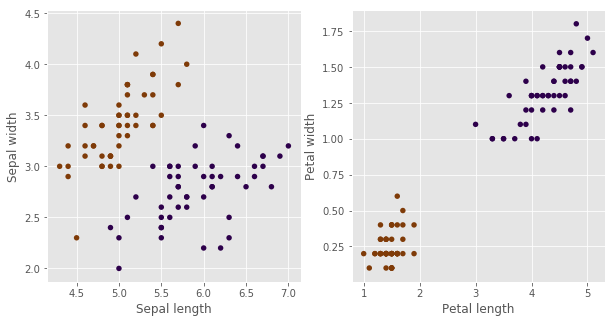

In [69]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [70]:
pred_iris = Clustering().fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Silhouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

# Silhouette

Выбрал этот критерий потому, что мой алгорим на вход принимает k, а удобная зубчатая визуализация 
позволяет решить какое k выбрать.

In [71]:
def dist(a, b):
    return np.sqrt(np.sum((a-b)**2))

def silhouette(x, c):
    si = np.zeros(len(x))
    C = np.unique(c)
    for i, xi in enumerate(x):
        dists = {t: [] for t in C}
        for j,cj in enumerate(c):
            if j != i:
                d = dist(xi, x[j])
                dists[cj].append(d)
        selfdists = dists.pop(c[i])
        ai = np.mean(selfdists) if selfdists else 0.0
        bi = min(
            [mean(dists[k]) for k in dists if dists[k]])
        si[i] = (bi-ai)/max(ai,bi)
    return np.mean(si)

def quality(x, y):
    return silhouette(x, y)

In [72]:
silhouette(x_iris, pred_iris)

0.7369368160680051

In [73]:
from sklearn.metrics import silhouette_score, silhouette_samples

In [74]:
silhouette_score(x_iris, pred_iris)

0.73693681602317374

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

0.639819838107
0.647174405828
0.648070232151
0.648096881702
0.649134652781
0.656421868498
0.656804913798
0.658296129002
0.65507282827
0.65261757727


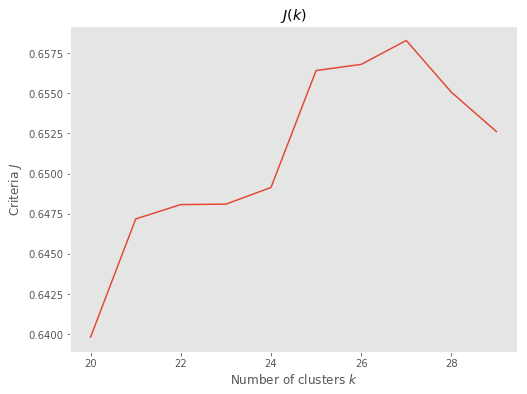

In [77]:
ks = range(20, 30)
criteria = np.zeros(len(ks))
y_list=[]

for i, k in enumerate(ks):
    cls = Clustering()
    y=cls.fit_predict(x_data_all[:500],k)
    y_list.append(y)
    criteria[i] = quality(x_data_all[:500], y)
    print(criteria[i])
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Выбираем k=27.

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [ ]:
k_final = 27
cls = Clustering()
y_twenty_seven = cls.fit_predict(x_data_all,k_final)

Визуализируем кластеризацию на карте

In [218]:
%matplotlib inline 
import folium
from folium.plugins import MarkerCluster
mos_center = [55.750475, 37.619020]
moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=True)

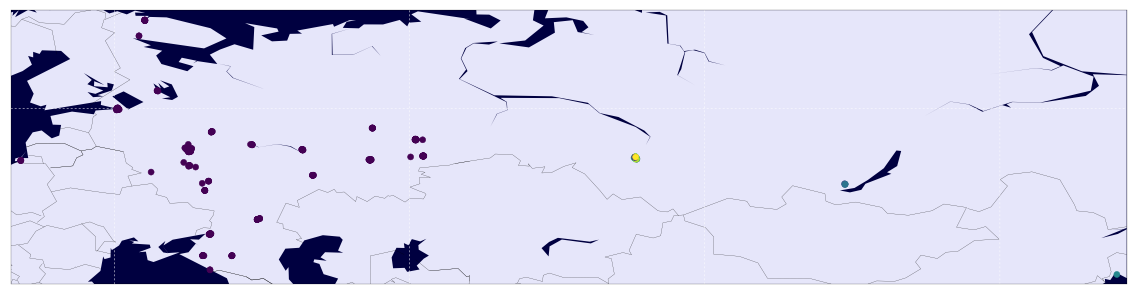

In [220]:
short_data=x_data_all[:500]
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(short_data[:, 0]) - 1, urcrnrlat=max(short_data[:, 0]) + 1, llcrnrlon=min(short_data[:, 1]) - 1, urcrnrlon=max(short_data[:, 1]) + 1, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(short_data[:, 1], short_data[:,0], c=y_twenty_seven, zorder=10)
    
pl.show()

In [261]:

mos_center = [55.750475, 37.619020]

In [273]:
moscow = folium.Map(location=mos_center, zoom_start=5, control_scale=True)

In [225]:
short_data_pd=pd.DataFrame(short_data)
y_twenty_seven_pd=pd.DataFrame(y_twenty_seven)

In [264]:
uniq=set()
for i in y_twenty_seven:
    uniq.add(int(i))

In [274]:
for i in xrange(len(uniq)):
    temp_samp=short_data_pd[short_data_pd[y_twenty_seven_pd==i][0]>0]
    marker_cluster = MarkerCluster(locations=temp_samp.values)
    marker_cluster.add_to(moscow)

In [275]:
moscow

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

In [40]:
# your code with maps here

Какой вывод можно сделать о качестве кластеризации?

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.